# Preamble

In [7]:
%run -i scripts/preamble.py

# Introduction

As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- Model Specific Research
- Data exploration, preprocessing and environment setup
- Model Replication and Experimentation

# Model Specific Research

*__Fill out details from readings__*

On the basis of my reasearch and published results, I have chosen to investigate the following models:

__Shallow__
- Logistic Regression
- Factorization Machines

__Deep__
- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

# Data Exploration, preprocessing and environment setup

## Exploratory Data Analysis

/tmp/ipykernel_25209/1746979306.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticks(),rotation=45)
/tmp/ipykernel_25209/1746979306.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks(),rotation=45)
/tmp/ipykernel_25209/1746979306.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticks(),rotation=45)


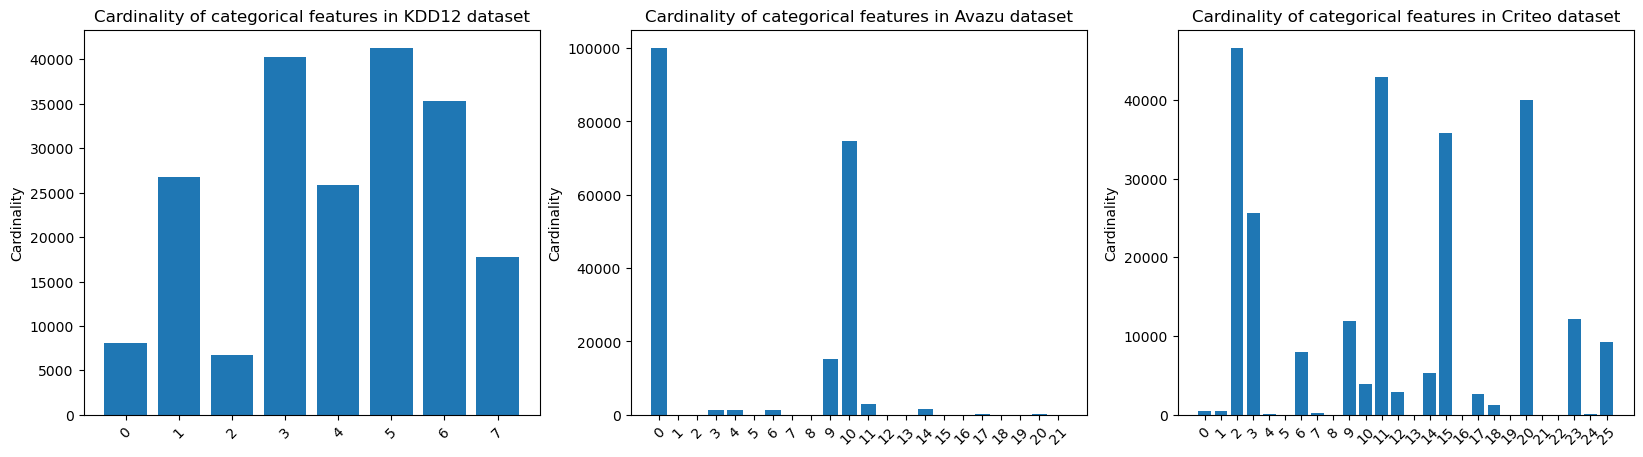

## Preprocessing

# Model Replication and Experimentation

In [44]:
%run -i scripts/modelling/load_and_prep_data.py

## Shallow Models

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- Logistic regression
- Factorization machines

### Logistic Regression

In [9]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.1624932290324095
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220097439364145
ROC AUC: 0.7187736358180423
Accuracy: 0.83205

Criteo:
Log loss: 0.4934802677435992
ROC AUC: 0.7450124095275694
Accuracy: 0.7671


### Factorization Machine

In [12]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 15.774504905747122
ROC AUC: 0.47794380839584155
Accuracy: 0.56235


## Deep Models

As explained above, I will be exploring the following deep models:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

### Factorization-Machine Supported Neural Networks

In [29]:
# Add this to the pramble
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [39]:
# Generate feature columns

## Define the dense columns
kdd12_dense_features = [col for col in kdd12_standardized.columns.tolist() if col not in kdd12_categorical_columns+['click']]
avazu_dense_features = [col for col in avazu_standardized.columns.tolist() if col not in avazu_categorical_columns+['click']]
criteo_dense_features = [col for col in criteo_standardized.columns.tolist() if col not in criteo_categorical_columns+['click']]

## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=kdd12_standardized[feat].unique().shape[0], embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat,1) for feat in kdd12_dense_features]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=avazu_standardized[feat].unique().shape[0], embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_dense_features]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=criteo_standardized[feat].unique().shape[0], embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_dense_features]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

## Get feature names
kdd12_feature_names = get_feature_names(kdd12_dnn_feature_columns + kdd12_linear_feature_columns)
avazu_feature_names = get_feature_names(avazu_dnn_feature_columns + avazu_linear_feature_columns)
criteo_feature_names = get_feature_names(criteo_dnn_feature_columns + criteo_linear_feature_columns)

In [41]:
# Define model inputs
kdd12_train_model_input = {name:kdd12_train_X[name].values for name in kdd12_feature_names}

In [43]:
kdd12_fixlen_feature_columns

[SparseFeat(name='DisplayURL', vocabulary_size=247, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f5599b10160>, embedding_name='DisplayURL', group_name='default_group', trainable=True),
 SparseFeat(name='AdID', vocabulary_size=192, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f557d8e8fa0>, embedding_name='AdID', group_name='default_group', trainable=True),
 SparseFeat(name='AdvertiserID', vocabulary_size=247, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f557d8e8a60>, embedding_name='AdvertiserID', group_name='default_group', trainable=True),
 SparseFeat(name='QueryID', vocabulary_size=82, embedding_dim=4, use_

In [42]:
kdd12_train_model_input

{'DisplayURL': array(['infrequent_sklearn', 'infrequent_sklearn', '0', ..., '67',
        'infrequent_sklearn', '13'], dtype=object),
 'AdID': array(['infrequent_sklearn', 'infrequent_sklearn', '289', ...,
        'infrequent_sklearn', 'infrequent_sklearn', '446'], dtype=object),
 'AdvertiserID': array(['infrequent_sklearn', 'infrequent_sklearn', '0', ..., '65',
        'infrequent_sklearn', '12'], dtype=object),
 'QueryID': array(['infrequent_sklearn', 'infrequent_sklearn', 'infrequent_sklearn',
        ..., 'infrequent_sklearn', 'infrequent_sklearn', '314'],
       dtype=object),
 'KeywordID': array(['infrequent_sklearn', 'infrequent_sklearn', 'infrequent_sklearn',
        ..., 'infrequent_sklearn', 'infrequent_sklearn', '393'],
       dtype=object),
 'TitleID': array(['infrequent_sklearn', 'infrequent_sklearn', 'infrequent_sklearn',
        ..., '596', 'infrequent_sklearn', '497'], dtype=object),
 'DescriptionID': array(['infrequent_sklearn', 'infrequent_sklearn', 'infrequent_sklear